In [246]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

import json

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.cross_validation as cross_validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [247]:
df_left = pd.read_csv('data/merged/look_left.csv')
df_right = pd.read_csv('data/merged/look_right.csv')
### hack
# Assume class 0 is always when face is forward for any data set
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df = pd.concat([df_left, df_right])
n = len(df)

In [248]:
config = json.loads(open('config.json','r').read())

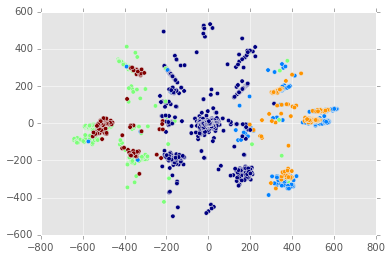

In [249]:
pca = PCA(n_components=2)
X = pca.fit_transform(df[config['active_features']])
plt.scatter(X[:,0],X[:,1], c=df['class'])

In [250]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

def train_split_classify(df, active_features, y_feature, clf, k = 4, verbose=False):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    classes = set(Y)
    accuracies = [[]]*len(classes)
    recalls = [[]]*len(classes)
    precisions = [[]]*len(classes)
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        for i in classes:
            id_rated_t = X_test.index[Y_pred == i]
            id_is_t = X_test.index[Y_test == i]
            n = len(X_test)
            truths = set(id_is_t)
            positives = set(id_rated_t)
            tp = len(truths.intersection(positives))
            fp = len(positives.difference(truths.intersection(positives)))
            fn = len(truths.difference(truths.intersection(positives)))
            tn = n - tp - fp - fn


            precision = tp / float(max([1,fp + tp]))
            recall = tp / float(max([1,tp + fn]))
            accuracy = (tp + tn) / float(n)
            accuracies[i].append(accuracy)
            recalls[i].append(recall)
            precisions[i].append(precision)
            if verbose==True:
                print "Class", i 
                print 'precision', precision
                print 'recall', recall
                print 'accuracy', accuracy
                print '\n======'
    
    metrics = []
    for i in classes:
        metrics.append(dict(
            label=i,
            precision=np.mean(precisions[i]),
            recall=np.mean(recalls[i]),
            accuracy=np.mean(accuracies[i]),
            classifier=clf.__class__,
            ))
    return metrics
#     print 'Confusion Matrix:', sum(cof_mat)
#     print 'Accuracy:', np.mean(accuracies)
#     print 'Recall:', np.mean(recalls)
#     print 'Precision:', np.mean(precisions)

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

res = []
svm = SVC()
res += train_split_classify(df, config['active_features'], 'class',svm)

rf = RandomForestClassifier()
res += train_split_classify(df, config['active_features'], 'class',rf)


knn = KNeighborsClassifier(n_neighbors=10)
res += train_split_classify(df, config['active_features'], 'class',knn)
df_res = pd.DataFrame(res)



Cross validating for <class 'sklearn.svm.classes.SVC'>


Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


In [252]:
df_res

,accuracy,classifier,label,precision,recall
0,0.929612,<class 'sklearn.svm.classes.SVC'>,0,0.164784,0.200000
1,0.929612,<class 'sklearn.svm.classes.SVC'>,1,0.164784,0.200000
2,0.929612,<class 'sklearn.svm.classes.SVC'>,2,0.164784,0.200000
3,0.929612,<class 'sklearn.svm.classes.SVC'>,3,0.164784,0.200000
4,0.929612,<class 'sklearn.svm.classes.SVC'>,4,0.164784,0.200000
5,0.993772,<class 'sklearn.ensemble.forest.RandomForestCl...,0,0.962579,0.952241
6,0.993772,<class 'sklearn.ensemble.forest.RandomForestCl...,1,0.962579,0.952241
7,0.993772,<class 'sklearn.ensemble.forest.RandomForestCl...,2,0.962579,0.952241
8,0.993772,<class 'sklearn.ensemble.forest.RandomForestCl...,3,0.962579,0.952241
9,0.993772,<class 'sklearn.ensemble.forest.RandomForestCl...,4,0.962579,0.952241
